<a href="https://colab.research.google.com/github/Rahul711sharma/Credit-Card-Default-/blob/main/Credit_Card_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective

* To predict the chances of Credit Card Default made by the Client.

##Importing Libraries

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.4MB 72kB/s 
     |████████████████████████████████| 204kB 21.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=a03ca785a9564b5ad01599a403b9021f2216317c62b62eb322caaab2fb248708
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [ ]:
import pyspark
import pyspark.sql as sql

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotly.express as pe


In [ ]:
sc = pyspark.SparkContext()

In [ ]:
sqlContext = pyspark.SQLContext(sc)

## Importing Data

In [ ]:
df = pd.read_excel("https://raw.githubusercontent.com/Rahul711sharma/Credit-Card-Default-/main/default%20of%20credit%20card%20clients.xls",header=1)


In [ ]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
sql_df = sqlContext.createDataFrame(df)

In [ ]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
sql_df.select('*').limit(10).show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

## Describe Data

In [ ]:
sql_df.summary().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+--------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|               ID|         LIMIT_BAL|               SEX|         EDUCATION|          MARRIAGE|              AGE|            PAY_0|               PAY_2|             PAY_3|               PAY_4|             PAY_5|            PAY_6|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|        BILL_AMT4|         BILL_AMT5|        BILL_AMT6|          PAY_AMT1|          PAY_AMT2|         PAY_AMT3|          PAY_AMT4|          PAY_AMT5|         PAY_AMT6|default payment next month|
+-------+-----------------+-

In [ ]:
type(sql_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
sql_df.toPandas().shape

(30000, 25)

##Null Values In data

In [ ]:
sql_df.filter(sql_df.SEX.isNull()).count()

0

In [ ]:
sql_df.toPandas().isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

##Exploratory Data 

In [ ]:
sql_df.createOrReplaceTempView('data')

In [ ]:
sql_df.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [ ]:
spark.sql(f"select SEX,count(*) as Count from data group by SEX").show()

+---+-----+
|SEX|Count|
+---+-----+
|  1|11888|
|  2|18112|
+---+-----+



In [ ]:
# Function to find distinct Values

def distinct_values(data):
  for i in data.columns:
    #distinct values of with less than 30 unique values
    if len(set(list(data[i])))<30:
      print(f"{i} Distinct Values :  \n {data[i].value_counts()} \n")

In [ ]:
distinct_values(sql_df.toPandas())


SEX Distinct Values :  
 2    18112
1    11888
Name: SEX, dtype: int64 

EDUCATION Distinct Values :  
 2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64 

MARRIAGE Distinct Values :  
 2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64 

PAY_0 Distinct Values :  
  0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64 

PAY_2 Distinct Values :  
  0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64 

PAY_3 Distinct Values :  
  0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64 

PAY_4 Distinct Values :  
  0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       3

In [ ]:
# Core Categorical Data
Cat_data = ['SEX','EDUCATION','MARRIAGE','default payment next month']

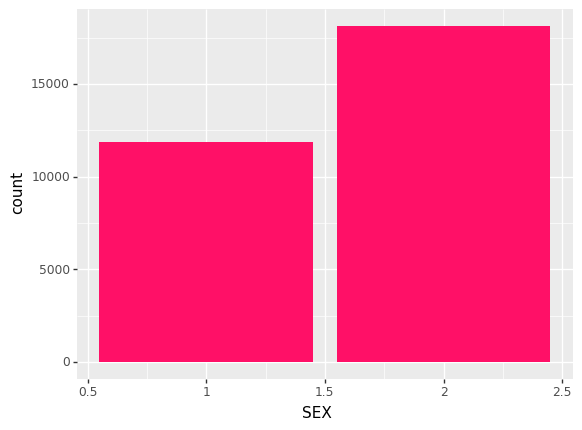

<ggplot: (8764043220137)>


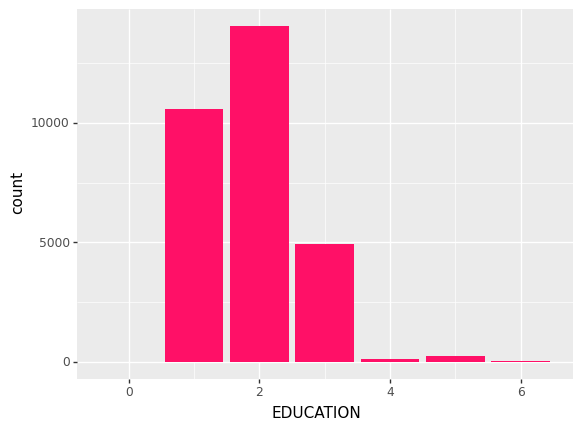

<ggplot: (8764045983553)>


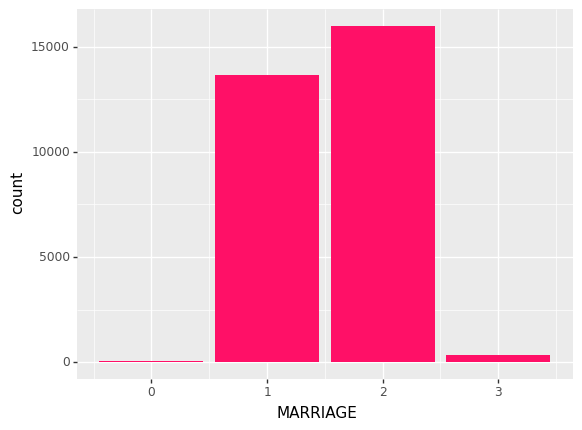

<ggplot: (8764043205745)>


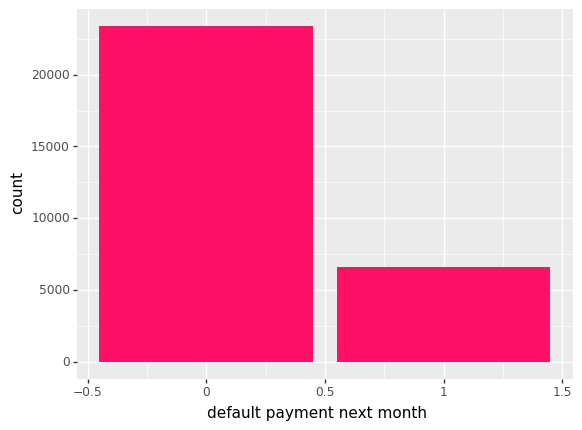

<ggplot: (8764083729601)>


In [ ]:
# Bar graphs
for i in Cat_data:
  print(ggplot(sql_df.toPandas())+aes(i,color=i)+geom_bar(fill = "#FF1067"))


Treatment of classes with close to none observations. We either remove them or add them to a majority class.

In [ ]:
df2 = sql_df.toPandas()

In [ ]:
df2['MARRIAGE']=df2['MARRIAGE'].replace({3:1,2:1,1:0})

In [ ]:
df2['EDUCATION'] = df2['EDUCATION'].replace({1:0,2:1,3:2,4:2,5:2,6:2})
df2['EDUCATION'].value_counts()

1    14030
0    10599
2     5371
Name: EDUCATION, dtype: int64

In [ ]:
df2['SEX']= df2['SEX'].replace({2:1,1:0})
df2['SEX'].value_counts()

1    18112
0    11888
Name: SEX, dtype: int64

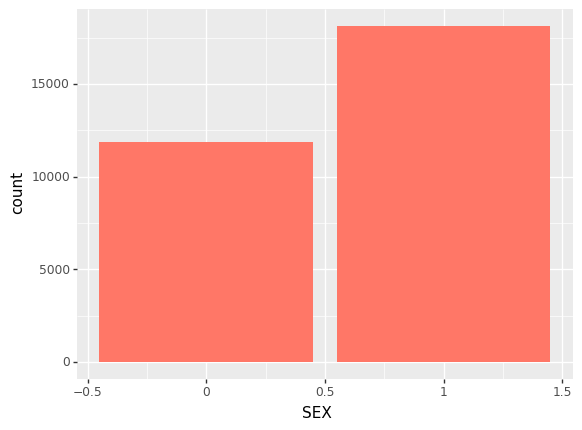

<ggplot: (8764044927981)>


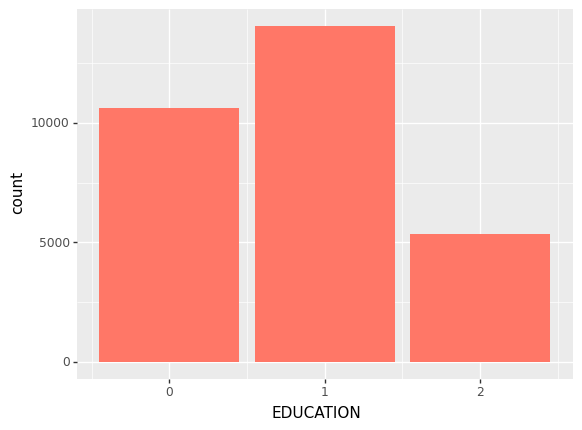

<ggplot: (8764045904877)>


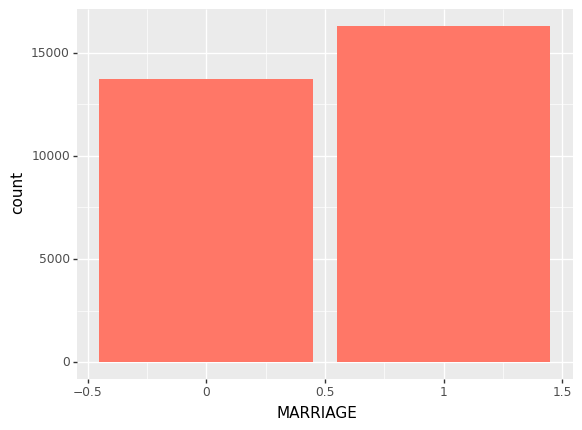

<ggplot: (8764047063773)>


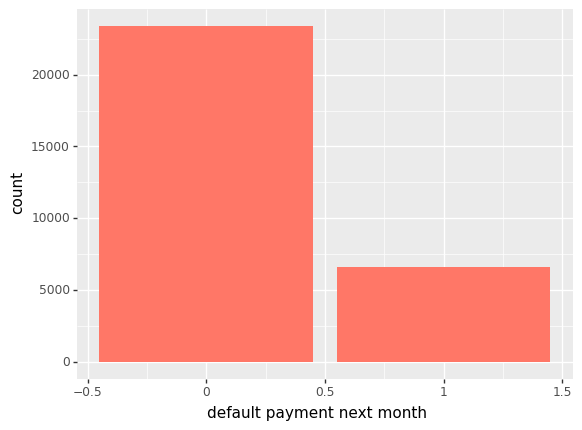

<ggplot: (8764044911149)>


In [ ]:
# Bar graphs
for i in Cat_data:
  print(ggplot(df2)+aes(i,color=i)+geom_bar(fill = "#FF7767"))


In [ ]:
distinct_values(df2)

SEX Distinct Values :  
 1    18112
0    11888
Name: SEX, dtype: int64 

EDUCATION Distinct Values :  
 1    14030
0    10599
2     5371
Name: EDUCATION, dtype: int64 

MARRIAGE Distinct Values :  
 1    16287
0    13713
Name: MARRIAGE, dtype: int64 

PAY_0 Distinct Values :  
  0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64 

PAY_2 Distinct Values :  
  0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64 

PAY_3 Distinct Values :  
  0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64 

PAY_4 Distinct Values :  
  0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 8        2
 1        2
Name: PAY_4, dtype: int64 



* We can see that our predictor has a majority class. We need to pick model and algorithms complying to that.


##Train test split 

In [ ]:
from sklearn.model_selection import train_test_split
